# Crew Scheduling



We consider 6 days with 4 places and want to schedule a bunch of flights connecting the places. One crew starts and ends at each place. The goal is to maximize the number of scheduled flights. All gaps in the schedule of a crew have to be filled with stays at the respective places. We give the gaps a higher negative completion time cost (-2) than the flights (-1) to ensure that scheduling flights has priority compared to scheduling stays. Because all completion time costs are negative, all non-scheduled tasks are pushed to the end of the planning horizon.

In [1]:

n_days = 6
days = range(n_days)
places = ['A','B','C','D']
crews = [ 'Crew_%s'%place for place in places ]

# Number of flights for each orig-dest pair
flights =\
{
('A','B') : 2,
('B','C') : 2,
('C','D') : 2,
('D','A') : 3,
('A','C') : 2,
('B','D') : 2
}

# Stays have to fill gaps, at most n_days-2 gaps can happen
stays =\
{
'A' : n_days-2,
'B' : n_days-2,
'C' : n_days-2,
'D' : n_days-2
}


# Solving

INFO: execution time for solving mip (sec) = 0.1706070899963379
INFO: objective = -288.0


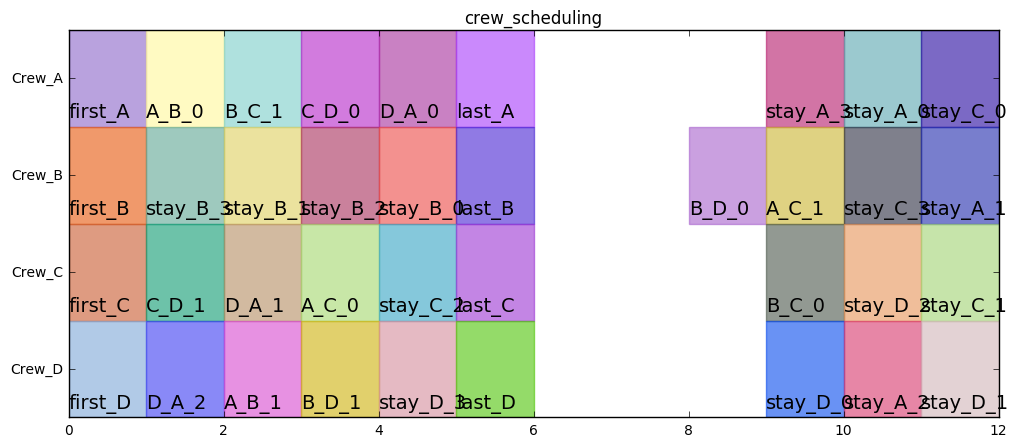

In [3]:

from pyschedule import Scenario, solvers, plotters, alt

# Create employee scheduling scenari
S = Scenario('crew_scheduling',horizon=2*n_days)

# Create crew resources
for crew in crews:
    S.Resource(crew)

# Create flight tasks
for orig,dest in flights.keys():
    for i in range(flights[orig,dest]):
        flight = S.Task('%s_%s_%i'%(orig,dest,i))
        flight.orig = orig
        flight.dest = dest
        flight += alt( S.resources() )
        # Push flight to end of planning horizon
        S += flight*-1

# Create start and end tasks of crews
for crew in crews:
    # Start task
    start = S.Task('first_%s'%crew[-1])
    start.dest = crew[-1]
    start.orig = None
    start += S[crew]
    S += start >= 0
    # End task
    end = S.Task('last_%s'%crew[-1])
    end.orig = crew[-1]
    end.dest = None
    end += S[crew]
    S += end <= n_days

# Create stay tasks
for place in stays:
    for i in range(stays[place]):
        stay = S.Task('stay_%s_%i'%(place,i))
        stay.orig = place
        stay.dest = place
        stay += alt( S.resources() )
        # Push stay to end of planning horizon (stronger than flights)
        S += stay*-2

# Connection constraints
for crew in crews:
    for place in places:
        for day in days:
            # Ensure that dest and orig are the same of consecutive tasks
            select = lambda T,t,place=place,day=day : T.dest==place and t==day or T.orig==place and t==day+1
            C = S[crew][select].diff <= 0
            # Select a customized name for capacity constraint
            C.name = 'Capacity_%s_%s_%i'%(crew,place,day)
            S += C

# solve and plot problem
if solvers.mip.solve(S,msg=1):
    %matplotlib inline
    plotters.matplotlib.plot(S,fig_size=(12,5))
else:
    print('no solution found')
    